<img src="image/hft_logo.jpg"
     alt="Hft Logo"
     align="right" 
     width="150" 
     height="150" />
# Mathematik Master Seminar
## Zeitreihenprognose mit Long short-term memory

---
### Philipp Dörich & Tim Oliver Walter
### 13. Dezember 2021

---

# Aufgabenstellung

### Art der Daten

Bei dem Datensatz handelt es sich um Messwerte der Feinstaub-Konzentration in der Luft Mailands.

Die Daten wurden mit einem sogennanten "Laserstreuenden" Sensor abgetastet.

Der Datensatz enthält stündliche Mittelwerte der Messungen vom **24.07.2020 - 20.09.2020**.

[1]

### Zielsetzung

Zeil ist es durch eine Zeitreihenanalyse und Implementieren eines maschinellen Lernmodells den Verlauf am **21.09.2020** zu prognostizieren.

# Pakete laden

Für das Analysiren einer Zeitreihe und das Erstellen eines neuronalen Netzes (LSTM) werden die folgenden Python-Pakete benötigt: 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use("fivethirtyeight")

# Datenimport

Bevor mit der Zeitreihenanalyse begonnen werden kann, werden die Daten importiert und es wird überprüft, ob die Daten korrekt konvertiert wurden. 

Anschließend wird in einen Datenüberblick überprüft, ob die Zeitreihe Lücken aufweist.

In [2]:
df = pd.read_csv("data/aq_milan_summer_2020.csv")
df.tail()

,local_datetime,pm2p5
1393,2020-09-20 19:00:00,20.25
1394,2020-09-20 20:00:00,22.75
1395,2020-09-20 21:00:00,27.50
1396,2020-09-20 22:00:00,27.50
1397,2020-09-20 23:00:00,31.75


### Datenüberblick

In [3]:
print("Null values local_datetime:", df.isnull().sum()[0])
print("Null values pm2p5:", df.isnull().sum()[1])

Null values local_datetime: 0
Null values pm2p5: 0


In [4]:
stats = df.describe().transpose()
stats = stats.rename({"count":"rows"},axis=1)
stats

,rows,mean,std,min,25%,50%,75%,max
pm2p5,1398.0,12.668863,8.568262,1.0,6.0,10.225,17.9375,52.0


# Datensatz in Zeitreihe konvertieren

Eine Zeitreihe $y_t$ besteht aus endlich vielen, zeitlich angeordneten Messwerten:

&nbsp;&nbsp; $x_{t_1}, x_{t_2}, \ldots, x_{t_T}$ &nbsp;&nbsp; mit &nbsp;&nbsp; $x_{t_k} \in \mathbb{R}^n$ &nbsp;&nbsp; und &nbsp;&nbsp; $k = 1, 2, \ldots, T$.

Wobei gilt: &nbsp;&nbsp; $t_1 < t_2 < \ldots < t_T$. 

Im Folgenden ist die Umsetzung im Quellcode zu sehen.

In [5]:
df = df.rename({
    "local_datetime":"ds",
    "pm2p5":"y"},
    axis=1)
df["ds"] = pd.to_datetime(df["ds"])
df = df.set_index("ds")
df.head()

,y
ds,
2020-07-24 18:00:00,11.67
2020-07-24 19:00:00,9.25
2020-07-24 20:00:00,6.29
2020-07-24 21:00:00,5.50
2020-07-24 22:00:00,9.50


Nicht alle Zeitreihen haben nur ein Beobachtungsmerkmal zum Zeitpunkt $t$.

Liegen zu jedem Zeitpunkt $t$ mehrere Beobachtungen ($n > 1$) vor, spricht man von **multivariaten** Zeitreihen.

 ### Beispiel multivariate Zeitreihe

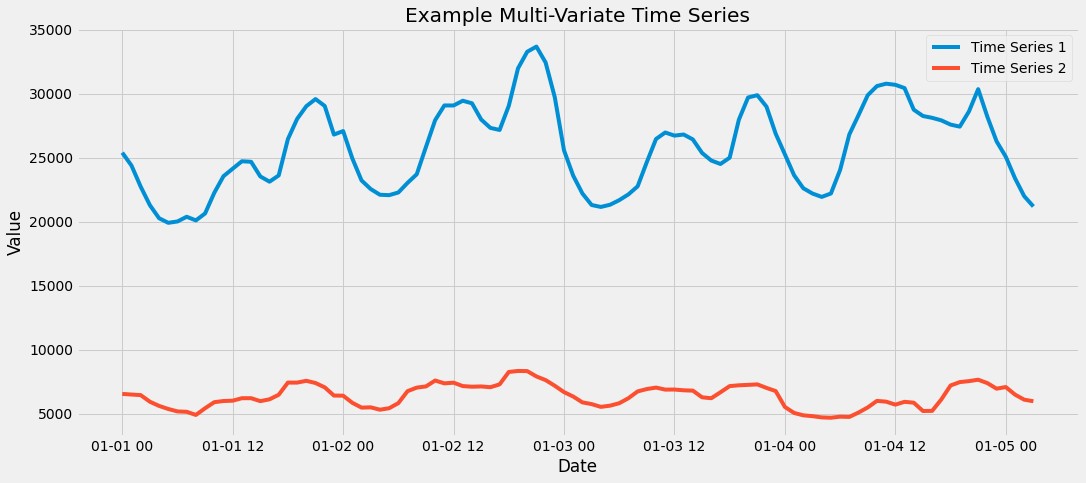

In [6]:
multi_df = pd.read_csv("data/multi.csv")
multi_df["time"] = pd.to_datetime(multi_df["time"])
multi_df = multi_df.set_index("time")
multi_df = multi_df.iloc[:100]

plt.figure(figsize=(16, 7))
plt.plot(multi_df)
plt.title("Example Multi-Variate Time Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(["Time Series 1","Time Series 2"])
plt.show()

# Explorative Datenanalyse

### Visuellen Darstellung der univariaten Zeitreihe

Man nennt eine Zeitreihe **skalar** oder **univariat**, wenn $n = 1$ gilt, also zu jedem Zeitpunkt nur eine Beobachtung vorliegt.

Aus dieser Definition wird klar, dass es sich bei der von uns betrachteten Zeitreihe um eine univariate Zeitreihe handelt. Sie wird wie folgt dargestellt. 

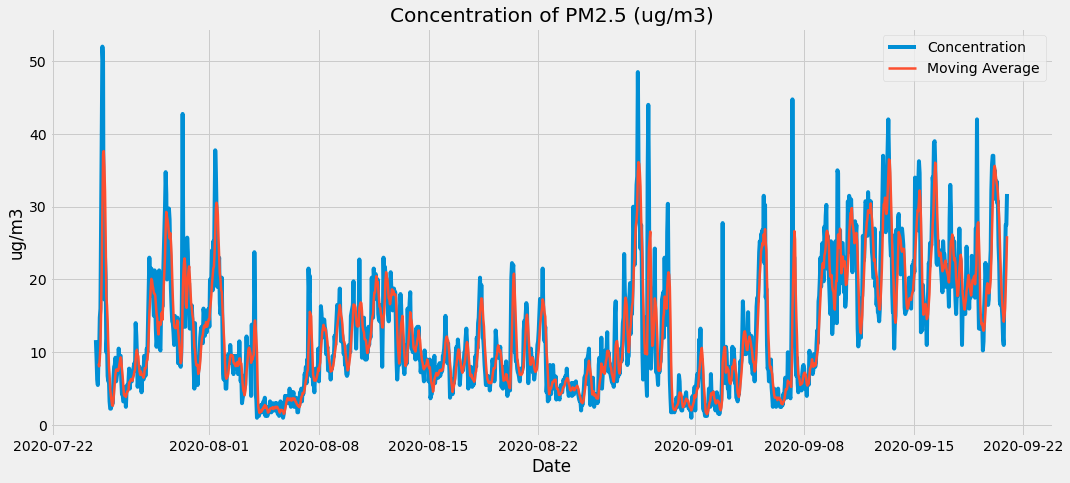

In [7]:
roll_mean = df.y.rolling(5).mean()
roll_std = df.y.rolling(5).std()

plt.figure(figsize=(16, 7))
plt.plot(df, label="Concentration")
plt.plot(roll_mean ,label="Moving Average",linewidth=2.5)
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

### Ausreißeranalyse

Boxplots fassen die in einem Datenbestand enthaltenen Informationen mithilfe von **5** wichtigen Zahlen zusammen. Die sogenannte Fünf-Punkte-Zusammenfassung einer Verteilung:

&nbsp;&nbsp; $x_{min} :=$ unterer Whisker

&nbsp;&nbsp; $x_{0.25} :=$ unteres Quantil

&nbsp;&nbsp; $x_{med} :=$ Median

&nbsp;&nbsp; $x_{0.75} :=$ oberes Quantil

&nbsp;&nbsp; $x_{max} :=$ oberer Whisker

![Boxplot](image/boxplot.jpg)

Die beiden Werte $x_{min}$ und $x_{max}$ informieren über den Datenausdehnungsbereich, ihre
Differenz ist die Spannweite $R$. Die linke und rechte Seite der Box, getrennt
durch die Linie des Medians, stellt jeweils 25% der Daten dar.

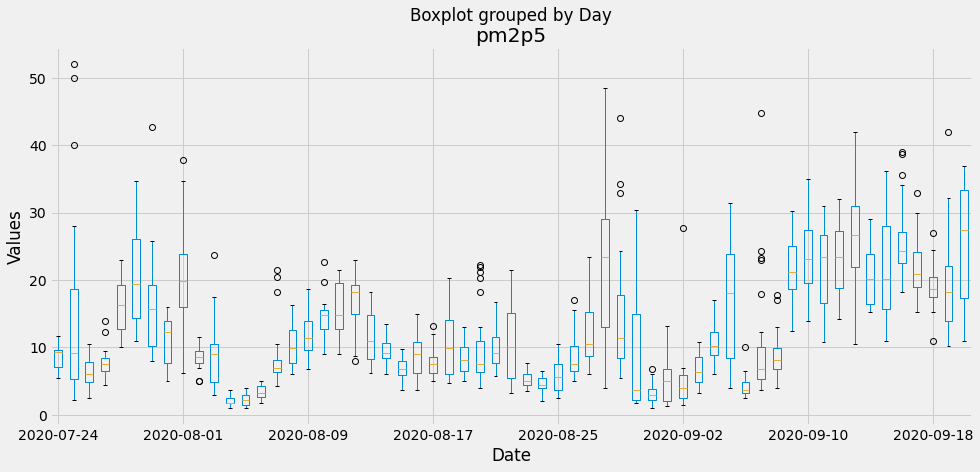

In [8]:
boxplot_df = df.copy()
boxplot_df["Day"] = boxplot_df.index.dayofyear
fig, ax = plt.subplots(figsize=(16, 7))
boxplot_df.boxplot(by ='Day', column =['y'], ax = ax)
ax.set_xticks(ax.get_xticks()[::8])
ax.set_xticklabels(boxplot_df.Day[::192].index.date)
plt.title("pm2p5")
plt.ylabel("Values")
plt.xlabel("Date")
plt.show()

$\Rightarrow$ *Aus den Boxplots ist zu erkennen, dass beispielsweise zwischen dem 24.07.2020 und dem 01.08.2020 Ausreißer zu erkennen sind. Diese werden durch schwarze Kreise dargestellt.*

### Häufigkeitsanalyse

Die Veranschaulichung der Häufigkeiten $h_j$ bzw. $f_j$ der Merkmalsausprägungen $x_j$ der
Klassen $j$ mit $j = 1, \ldots , M$ heißt Histogramm. Dazu werden Rechtecke über den Klassen

&nbsp;&nbsp; $[a_j ,b_j)$ mit $j = 1, \ldots, M$

mit einer Höhe proportional zu
&nbsp;&nbsp; $h^∗_j = \frac{h_j}{(b_j − a_j )}$ &nbsp;&nbsp; bzw. &nbsp;&nbsp; $f^∗_j = \frac{f_j}{(b_j − a_j )}$

gezeichnet. $f^*_j$ wird auch als Häufigkeitsdichte bezeichnet und gibt an, wie dicht die Beobachtungen im entsprechenden Intervall liegen.

![Histogramm](image/histogramm.jpg)

Die Abbildung zeigt den Zusammenhang zwischen der absoluten Häufigkeit $h_j$ und der Höhe $h^∗_j$ graphisch.

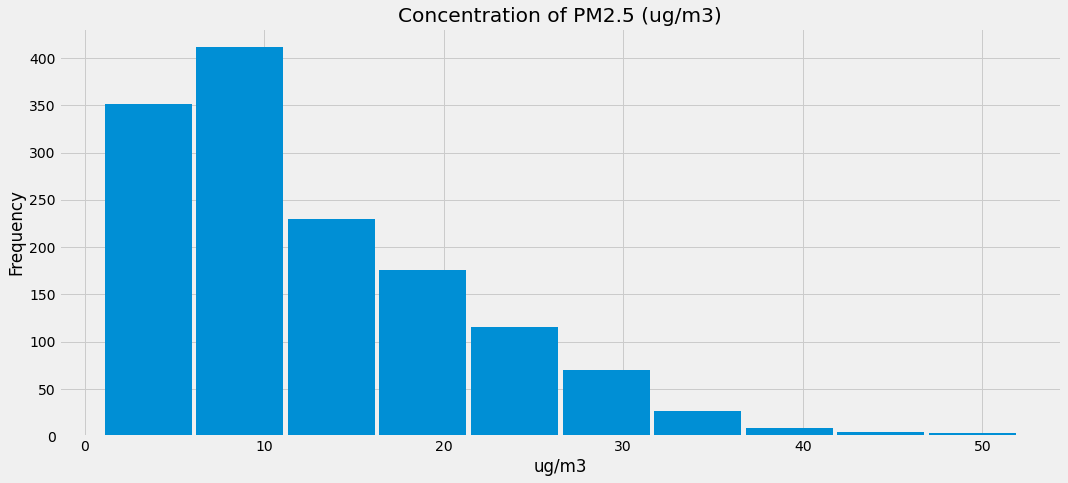

In [9]:
plt.figure(figsize=(16, 7))
plt.hist(df, rwidth = 0.95)
plt.xlabel("ug/m3")
plt.ylabel("Frequency")
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

$\Rightarrow$ *Aus dem Histogramm lässt sich nun ableiten, dass mehr als die $50$% der Datenpunkte eine Feinstaubbelastung von unter 10 ug/m3 aufweisen.*

### Zerlegung der Zeitreihe

Eine Zeitreihe $y_t$ lässt sich analog zu unserer obigen Definition, auf zwei Arten beschreiben:

Additiv: &nbsp;&nbsp; $y_t = S_t + T_t + R_t$

Multiplikativ: &nbsp;&nbsp; $y_t = S_t \cdot T_t \cdot R_t$

Dies ist von Vorteil, da in Zeitreihen oft mehrere Muster enthalten sind. Um diese Muster darstellen zu können wird die Zeitreihe in verschiedene Komponenten aufgeteilt. Die Komponenten sind wie folgt definiert:

$S_t :=$ Sesonalität

$T_t :=$ Trend

$R_t :=$ Rauschen

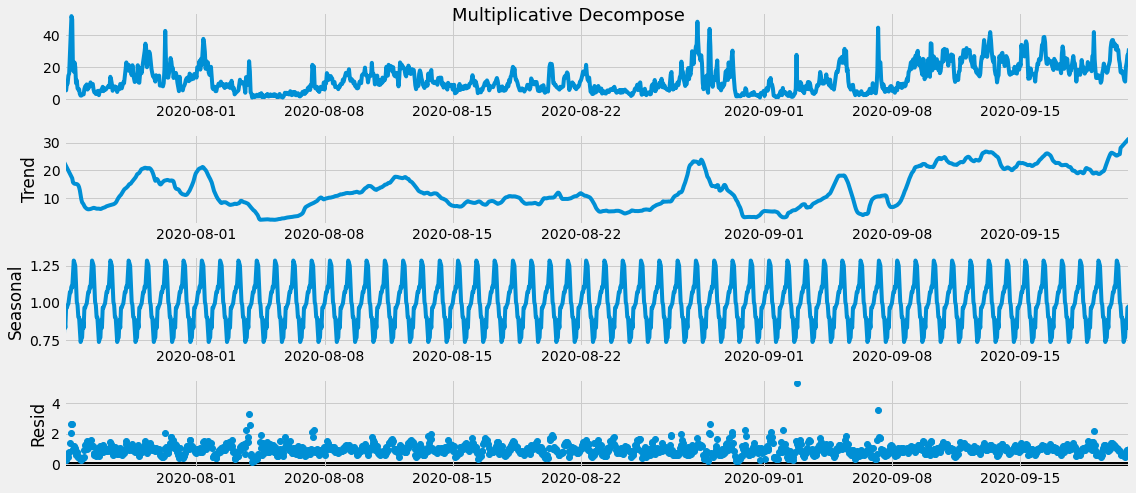

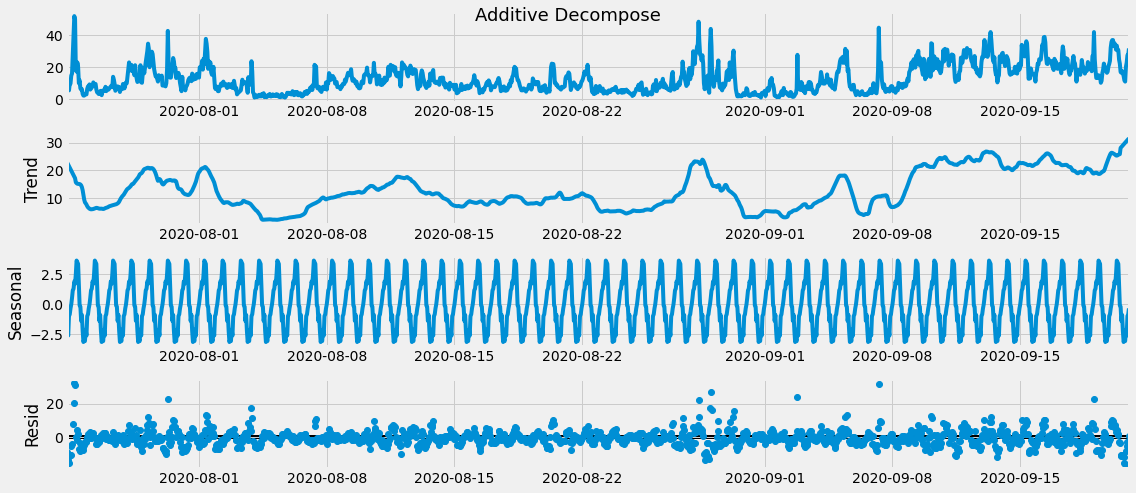

In [10]:
decompose_result_add = seasonal_decompose(df, model="additive", extrapolate_trend="freq")
decompose_result_mul = seasonal_decompose(df, model="multiplicative", extrapolate_trend="freq")

plt.rcParams.update({'figure.figsize': (16, 7)})
decompose_result_mul.plot().suptitle("Multiplicative Decompose", fontsize=18)
decompose_result_add.plot().suptitle("Additive Decompose", fontsize=18)
plt.show()

$\Rightarrow$ *Da die additive und multiplikative Zerlegung einer Zeitreihe im mathematischen Sinne "äquivalent" ist, empfiehlt es sich auf Basis des Rauschens die additive Zerlegung zu verwenden.* 

*Diese Zerlegung weist eine gewisse Zufälligkeit auf, welche in der Statistik oft wünschenswert ist.*

### Korrelationsanalyse

**Autokerrelation (ACF)** misst den Zusammenhang zwischen den gemessenen Werten einer Zeitreihe, sie ist der *Korelationskoeffizient* zwischen zwei Zufallsvariablen $Y_t$ und $Y_{t + \tau}$. Hierbei beschreibt $\tau$ die Zeitdifferenz zwischen den beiden Zufallsvariablen. $\tau$ wird in diesem Zusammenhang auch als **Lag** bezeichnet.

Die ACF ist wie folgt definiert: &nbsp;&nbsp; $\rho(\tau) := \frac{Cov( Y_t, \; Y_{t + \tau})}{Var(Y_t)}$

Die **partielle Autokorrelation (PACF)** ist durch die ACF eindeutig bestimmt.

Mathematisch kann die PACF folgendermaßen beschrieben werden: $\pi(\tau) := \begin{cases}
        \Phi_{\tau, \tau} \;\;\;\;\;\;  \tau > 0\\
        1 \;\;\;\;\;\;\;\;\;\; \tau = 0\\
        \pi(-\tau) \;\;\;\; \tau < 0
    \end{cases}$
    
$\Phi_{\tau, \tau}$ beschreibt in der obigen Definition den Regressionskoeffizienten für den Regressionsansatz der Zufallsvariable $Y_{t + \tau}$.

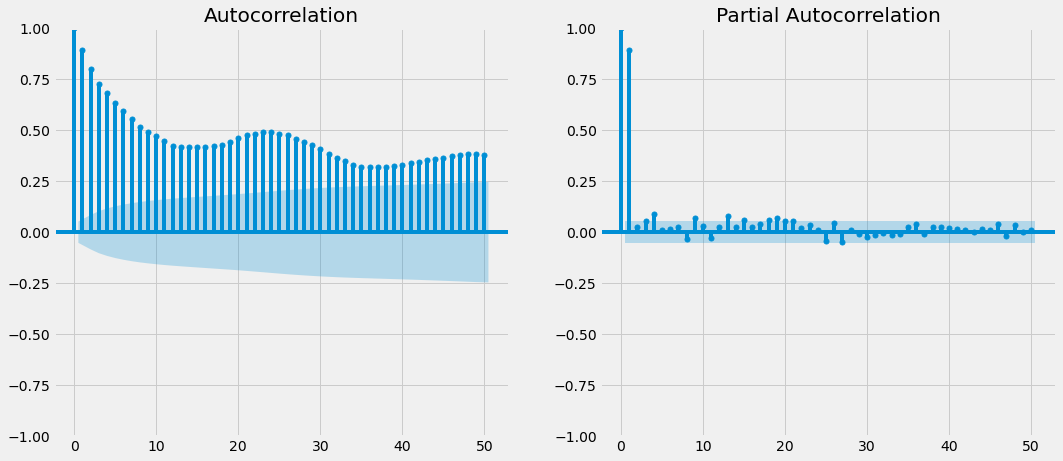

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 7))
plot_acf(df,lags=50, ax=ax1)
plot_pacf(df,lags=50, ax=ax2)
plt.show()

$\Rightarrow$ *Da die einzelnen Lags in beiden Abbildungen nicht vollständig in ihren jeweiligen Konfidenzintervallen liegen, korrelieren die Werte miteinander.*

### Test auf Stationarität

Für verschiedene Algorithmen des Maschinellen Lernens ist es wichtig, festzustellen ob die Zeitreihe $y_t$ einen Trend aufweist.
Um den Trend nachzuweisen oder zu widerlegen verwendet man statistische Tests auf Stationarität, sogenannte **Einheitswurzel-Tests**.
Denn grundsätzlich gilt: **Eine stationäre Zeitreihe hat keinen Trend**.
Der generelle Ansatz für den Einheitswurzel-Test besteht darin die Zeitreihe folgendermaßen darzustellen: 

&nbsp;&nbsp; $y_t = D_t + z_t + \varepsilon_t$

mit: 

- $D_t = S_t + T_t + R_t$ &nbsp;&nbsp; oder &nbsp;&nbsp; $S_t \cdot T_t \cdot R_t$ &nbsp;&nbsp; je nachdem wie die Zeitreihe zerlegt wurde.
- $z_t =$ stochastische Komponente
- $\varepsilon_t =$ ststionärer Fehler

Die Aufgabe des Einheitswurzel-Tests besteht darin festzustellen ob die stochastische Komponente $z_t$ eine Einheitswurzel enthält oder stationär ist.

Es gibt eine Vielzahl an Einheitswurzel-Tests für stochastische Prozesse. Der **augumented Dickey-Fuller-Test (ADF)** ist einer der am meist genutzten und für große Datensätze, wie in unserem Fall, geeignet. Der ADF-Test liefert als Ergebnis drei verschiedene Komponenten:

1. ADF Statistic:
    1. ADF Statistic $< 0$ stationär.
    2. ADF Statistic $\geq 0$ nicht stationär. 
2. p-value:
    1. p-value $> 0.05$ bedeutet nicht-stationär. 
    2. p-value $\leq 0.05$ bedeutet stationär.
3. Critical Values

Gibt es einen Widerspruch zwischen 1. und 2. muss 3. zusätzlich betrachtet werden um eine Aussage über stationarität oder nicht-stationarität.

In [12]:
adf_result = adfuller(df)
print('ADF Statistic: %.3f' % adf_result[0])
print('p-value: %.3f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.749
p-value: 0.066
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


![Histogramm](image/adfErgebnis.jpg)

# Neuronale Netze

### Rekurrente Neuronale Netze

Rekurrente Neuronale Netze **(RNN)** wurden entwickelt, um das "Gedächtnisproblem" bei Feedforward-Netzwerken zu lösen. RNN eignen sich somit vor allem für das Verarbeiten von sequenziellen Daten wie beispielsweise Zeitreihen. Eine Zelle eines RNN kann wie folgt visualisiert werden: 

![RNN-Zelle](image/rnnZelle.jpg)

Der Aktivierungsfunktion $\sigma_h$ wird zum Zeitpunkt $t$ die Eingabe $x_t$ und die vergangene Aktivierung $h_{t-1}$ übergeben. Mit Hilfe der Aktivierungsfunktion wird nun die Aktivierung $h_t$ berechnet. Mit der vorherigen Aktivierung $h_{t-1}$ wird nun die Ausgabe $y_t$ zum Zeitpunkt $t$ berechnet. 

### Skalierung der Zeitreihe

Neuronale Netze reagieren teilweise sehr empfindlich auf Ausreiser, dadurch kann es in manchen Fällen vorkommen, dass das Netz nicht das eigentlich zu lösende Problem erlernt. Daher werden, um den Lernprozess nicht unnötig zu verlangsamen, alle Daten auf das Intervall $[0, 1]$ skalliert, dadurch werden Ausreiser weniger stark gewichtet. 

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[["y"]] = scaler.fit_transform(df[["y"]])

### Aufteilen in Trainings- und Testmenge

In [14]:
y_train, y_test =train_test_split(df,shuffle=False, test_size=0.3)

print(f'Train: {y_train.shape}')
print(f'Test: {y_test.shape}')

Train: (978, 1)
Test: (420, 1)


### Sampling

In [15]:
def sampling(sequence, n_steps):
    X, Y = list(), list()
    for i in range(len(sequence)):
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
            
        x, y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)

In [16]:
n_steps = 3
n_features = 1

X_train, Y_train = sampling(y_train["y"].tolist(), n_steps)

for i in range(5):
    print(f'x = {X_train[i]}' + f'   ' + f'h_t = {round(Y_train[i], 8)}')
    print( )

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test, Y_test = sampling(y_test["y"].tolist(), n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

x = [0.20921569 0.16176471 0.10372549]   h_t = 0.08823529

x = [0.16176471 0.10372549 0.08823529]   h_t = 0.16666667

x = [0.10372549 0.08823529 0.16666667]   h_t = 0.17156863

x = [0.08823529 0.16666667 0.17156863]   h_t = 0.26960784

x = [0.16666667 0.17156863 0.26960784]   h_t = 0.29411765



### Long short-term memory

![lstmZelle](image/lstmZelle.jpg)

**Long Short-Term Memory-Netzwerke (LSTM)** sind RNN. Im Gegensatz zu ursprünglichen RNN-Zellen erhalten die LSTM-Zellen, neben der Eingabe $x_t$ und der Aktivierung aus dem vorherigen Zeitschritt $h_{t-1}$, auch den Zellzustand $c_{t-1}$, der als Gedächtnis der Einheit fungiert.

***TODO***

### Entwickeln eines LSTM-Modells

In [17]:
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, Y_train,validation_data=(X_test, Y_test),epochs=8, batch_size=50,verbose=1)

Epoch 1/8
20/20 [==============================] - 1s 12ms/step - loss: 0.0452 - val_loss: 0.1147
Epoch 2/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.0633
Epoch 3/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0161 - val_loss: 0.0385
Epoch 4/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0347
Epoch 5/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0280
Epoch 6/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0213
Epoch 7/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0184
Epoch 8/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0140


### Validierung des Modells

Bei der Validierung eines mit einem neuronalen Netz erzeugten Zeitreihe-Prognose-Modells wird versucht, den Fehler zu minimieren. Daraus entsteht ein sogenanntes Optimierungs-Problem. Die zu optimierende Funktion wird **"Verlust-Funktion" (Loss-Function)** genannt. 
Unser speziefisches Vorhersage-Problem, zählt in den Bereich der Regressionsprobleme, hier wird als Verlust-Funktion der mittlere quadratische Fehler (MSE) verwendet.

Die **mittlere quadratische Abweichung (mean squared error - MSE)** ist ein häufig verwendetes Maß zur Fehlerabschätzung bei Prognose-Algorithmen für Zeitreihen. Der MSE kann mathematisch wie folgt definiert werden:

&nbsp;&nbsp; $MSE(y_t, y_t^*) := \frac{1}{n} \sum_{i = 0}^{n - 1} ({y_t}_i - {y_t^*}_i)^2$

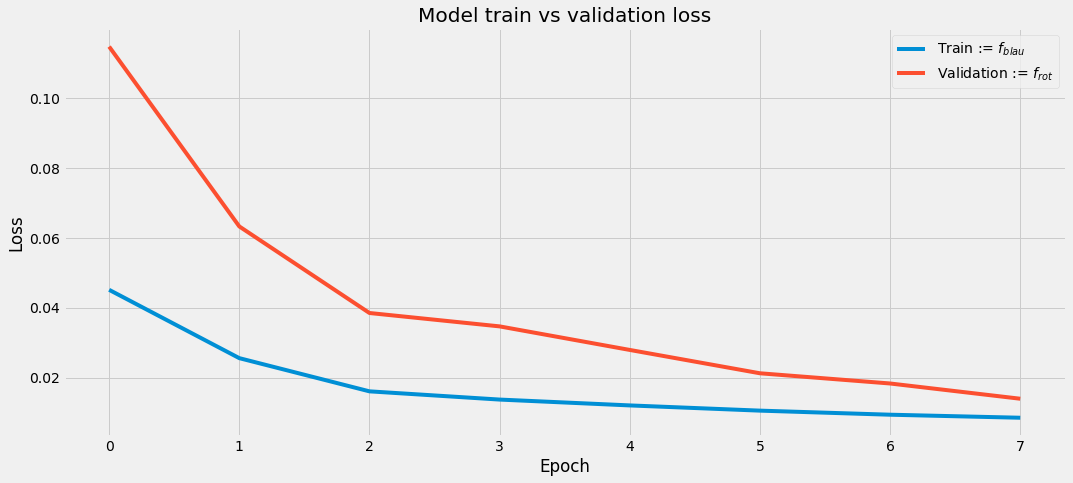

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model train vs validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train := $f_{blau}$", "Validation := $f_{rot}$"])
plt.show()

Die Abbildung zeigt die Verlust-Funktion der Trainings-Menge $f_{blau}$ und der Test-Menge $f_{rot}$. 

Im Idealfall gilt: 
1. Für jede Epoche $e \in E$: $f_{blau} < f_{rot}$
2. $\forall e_1, e_2 \in E$ mit $e_1 < e_2$ gilt: $f_{blau}(e_1) > f_{blau}(e_2)$
3. $\forall e_1, e_2 \in E$ mit $e_1 < e_2$ gilt: $f_{rot}(e_1) > f_{rot}(e_2)$
4. $\lim \limits_{e \rightarrow \infty} f_{blau}(e) = 0$
5. $\lim \limits_{e \rightarrow \infty} f_{rot}(e) = 0$

In [20]:
y_train = y_train.iloc[n_steps:,:]
y_test = y_test.iloc[n_steps:,:]

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

y_train["pred_train"] = pd.Series(train_pred.flatten(), index=y_train.index)
y_test["pred_test"] = pd.Series(test_pred.flatten(), index=y_test.index)

Die **Wurzel der mittleren quadratischen Abweichung (root mean squared error - RMSE)** ist definiert als: 

&nbsp;&nbsp; $RMSE(y_t, y_t^*) := \sqrt{MSE(y_t, y_t^*)}$



In [21]:
train_score = mean_squared_error(y_train.y,y_train.pred_train)
print('Train Score: %.4f MSE' % (train_score))
print('Train Score: %.4f RMSE' % (np.sqrt(train_score)))

test_score = mean_squared_error(y_test.y,y_test.pred_test)
print('Test Score: %.4f MSE' % (test_score))
print('Test Score: %.4f RMSE' % (np.sqrt(test_score)))

Train Score: 0.0082 MSE
Train Score: 0.0907 RMSE
Test Score: 0.0140 MSE
Test Score: 0.1184 RMSE


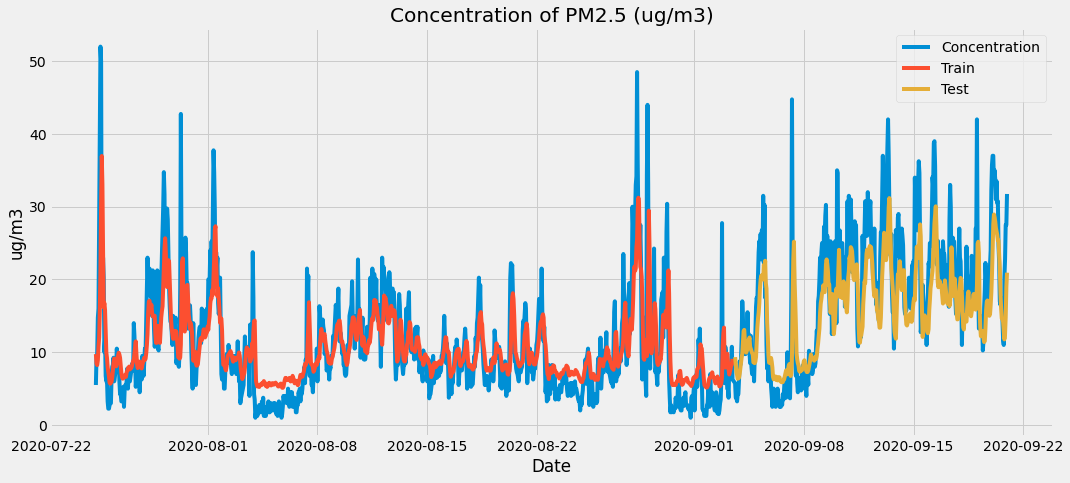

In [22]:
result= pd.concat([y_train,y_test])
result[["y","pred_train","pred_test"]] = scaler.inverse_transform(result[["y","pred_train","pred_test"]])

plt.plot(result.y,label="Concentration")
plt.plot(result.pred_train, label="Train")
plt.plot(result.pred_test, label="Test")
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

# Vorhersage

In [23]:
pred = model.predict(X_test[-24:])
index=pd.date_range(start="2020-09-20 23:00:00", periods=24, freq="H")
pred_df = pd.DataFrame(pred.flatten(), index=index, columns=["pred"])

result= pd.concat([result,pred_df])
result[["pred"]] = scaler.inverse_transform(result[["pred"]])

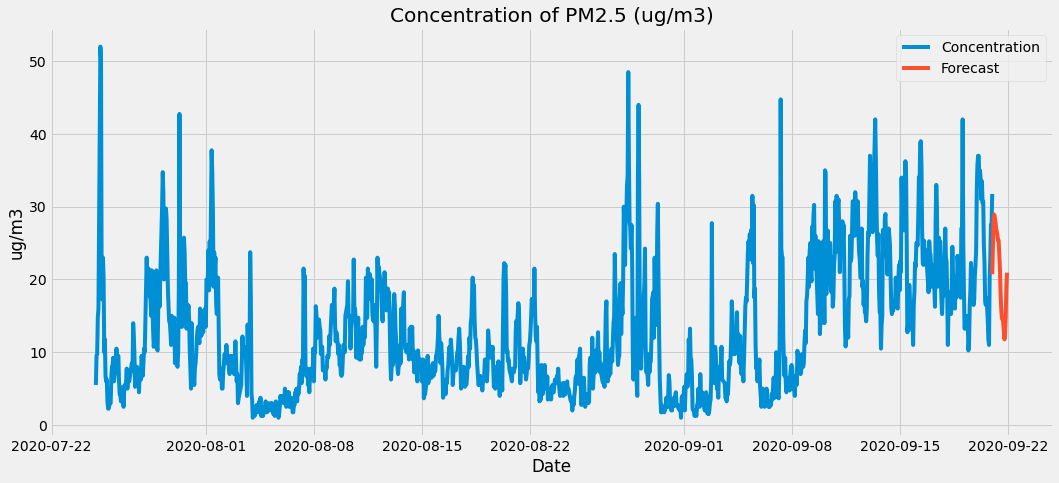

In [24]:
forecast = result[["y","pred"]]

plt.plot(forecast.y, label="Concentration")
plt.plot(forecast.pred ,label="Forecast")
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

# Quellenverzeichnis

[1] https://www.kaggle.com/wiseair/air-quality-in-milan-summer-2020

[2]

[3]

[4]